In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

In [3]:
# get possible edges in a grid
def get_edges(num_rows, num_cols):
    edges = {}
    for row in range(num_rows):
        for col in range(num_cols):
            neighbors = []
            if row - 1 >= 0:
                neighbors.append((row - 1, col))
            if row + 1 < num_rows:
                neighbors.append((row + 1, col))
            if col - 1 >= 0:
                neighbors.append((row, col - 1))
            if col + 1 < num_cols:
                neighbors.append((row, col + 1))

            edges[row * num_cols + col] = neighbors
    return edges

In [4]:
# genrate x = (x1,x2, ..., x25) using gibbs sampling
# order: x1 x2 x3 x4 x5
#        x6 x7 x8 x9 x10
#        x11 x12 x13 x14 x15
#        x16 x17 x18 x19 x20
#        x21 x22 x23 x24 x25
def gibbs_generate_x(num_rows, num_cols, num_iterations):
    # draw random values from [0,1] and place them on a grid
    grid = np.random.randint(0, 2, (num_rows, num_cols))

    # per each node get possible edges
    edges = get_edges(num_rows, num_cols)

    # save tuples of all rows and columns for convenient iteration
    rows = [i for i in range(num_rows) for _ in range(num_cols)]
    cols = list(range(num_cols)) * num_rows

    # iterations
    for i in range(0, num_iterations):
        # iterate over grid indices
        for row, col in zip(rows, cols):
            neighbors = edges[row * num_cols + col]
            # iterate over neighbors
            x_eq_0 = 0  # sum indicators of x_i with all the neighbors when x_i=0
            x_eq_1 = 0  # sum indicators of x_i with all the neighbors when x_i=1
            for neighbor_row, neighbor_col in neighbors:
                x_eq_0 += 1 if grid[neighbor_row, neighbor_col] == 0 else 0
                x_eq_1 += 1 if grid[neighbor_row, neighbor_col] == 1 else 0

            p_x_eq_0_given_neighbors = np.exp(x_eq_0) / (np.exp(x_eq_0) + np.exp(x_eq_1))  # p(xi=0|x1,...,x25)
            grid[row, col] = 0 if np.random.rand() < p_x_eq_0_given_neighbors else 1  # generate value

    return grid

In [5]:
# generate y_i from normal distribution with mu=x_i and sigma_i=1
def generate_y(num_rows, num_cols, grid):
    y_grid = np.zeros(grid.shape)

    # save tuples of all rows and columns for convenient iteration
    rows = [i for i in range(num_rows) for _ in range(num_cols)]
    cols = list(range(num_cols)) * num_rows

    # generate y_grid
    for row, col in zip(rows, cols):
        y_grid[row, col] = np.random.normal(grid[row, col], 1)

    return y_grid

In [10]:
# computing the correct marginal distribution according to p(x_i|y) = sigma_over_X\x_i{p(x_i,X|y)}
# fixed_index and vixed val - the x_i index and value that will not be changed
def correct_marginal(fixed_index, xi_val, y_grid, num_rows, num_cols):
    # per each node get possible edges
    edges = get_edges(num_rows, num_cols)

    # save tuples of all rows and columns for convenient iteration
    rows = [i for i in range(num_rows) for _ in range(num_cols)]
    cols = list(range(num_cols)) * num_rows

    # get all combinations of X\x_i
    combinations = list(map(list, itertools.product([0, 1], repeat=num_rows * num_cols - 1)))
    exp_sum_0 = exp_sum_1 = 0

    # per each X compute p(X|Y)
    for iteration, comb in enumerate(combinations):
        comb_0 = list(comb)
        comb_1 = list(comb)

        comb_0.insert(fixed_index, 0)  # insert x_i=0 at the relevant position
        comb_1.insert(fixed_index, 1)  # insert x_i=1 at the relevant position

        grid_0 = np.asarray(comb_0).reshape(num_rows, num_cols)  # build grid from the current permutation with x_i=0
        grid_1 = np.asarray(comb_1).reshape(num_rows, num_cols)  # build grid from the current permutation with x_i=1

        psi_xi_xj_0 = psi_xi_xj_1 = 0

        # iterate over grid indices
        for row, col in zip(rows, cols):
            neighbors = edges[row * num_cols + col]

            # iterate over neighbors
            for neighbor_row, neighbor_col in neighbors:
                psi_xi_xj_0 += 1 if grid_0[neighbor_row, neighbor_col] == grid_0[row, col] else 0
                psi_xi_xj_1 += 1 if grid_1[neighbor_row, neighbor_col] == grid_1[row, col] else 0

        psi_xi_yi_0 = np.sum(-0.5 * (grid_0 - y_grid) ** 2)
        psi_xi_yi_1 = np.sum(-0.5 * (grid_1 - y_grid) ** 2)

        exp_sum_0 += np.exp(psi_xi_xj_0 + psi_xi_yi_0)  # exp^(sigama_psi_ij(x_i,x_j) + sigama_psi_i(x_i,y_i))
        exp_sum_1 += np.exp(psi_xi_xj_1 + psi_xi_yi_1)  # exp^(sigama_psi_ij(x_i,x_j) + sigama_psi_i(x_i,y_i))

    p_xi_given_y = exp_sum_0 / (exp_sum_0 + exp_sum_1) if xi_val == 0 else exp_sum_1 / (exp_sum_0 + exp_sum_1)  # p(x_i=0 | y1,...,y25) or p(x_i=1 | y1,...,y25)
    return p_xi_given_y

In [7]:
def gibbs_generate_x_given_y(num_rows, num_cols, num_iterations):

    # draw random values from [0,1] and place them on a grid
    grid = np.random.randint(0, 2, (num_rows, num_cols))

    # save all generated values
    grid_array = []
    grid_array.append(grid.copy())

    # per each node get possible edges
    edges = get_edges(num_rows, num_cols)

    # save tuples of all rows and columns for convenient iteration
    rows = [i for i in range(num_rows) for _ in range(num_cols)]
    cols = list(range(num_cols)) * num_rows

    # iterations
    for i in range(0, num_iterations):
        # iterate over grid indices
        for row, col in zip(rows, cols):
            neighbors = edges[row * num_cols + col]
            # iterate over neighbors
            psi_xi_xj_0 = 0  # sum indicators of x_i with all the neighbors when x_i=0
            psi_xi_xj_1 = 0  # sum indicators of x_i with all the neighbors when x_i=1

            # compute psi(x_i,x_j) for all neighbors of x_i
            for neighbor_row, neighbor_col in neighbors:
                psi_xi_xj_0 += 1 if grid[neighbor_row, neighbor_col] == 0 else 0
                psi_xi_xj_1 += 1 if grid[neighbor_row, neighbor_col] == 1 else 0

            # compute psi(x_i,y_i)
            psi_xi_yi_0 = np.sum(-0.5 * (0 - y_grid[row][col]) ** 2)
            psi_xi_yi_1 = np.sum(-0.5 * (1 - y_grid[row][col]) ** 2)

            # get probability for p(x_i=0|X\x_i,y1,...yn)
            p_x_eq_0_given_all_others = np.exp(psi_xi_xj_0 + psi_xi_yi_0) / (np.exp(psi_xi_xj_0 + psi_xi_yi_0) + np.exp(psi_xi_xj_1 + psi_xi_yi_1))  # p(xi=0|x1,...,x25, y1, ..., y25)

            # draw value from ~[p(x_i=0|X\x_i,y1,...yn),p(x_i=1|X\x_i,y1,...yn)]
            grid[row, col] = 0 if np.random.rand() < p_x_eq_0_given_all_others else 1  # generate value
        grid_array.append(grid.copy())

    return grid_array


In [8]:
def correct_vs_gibbs(x_grid, y_grid, num_rows, num_cols, num_iterations):

    # save tuples of all rows and columns for convenient iteration
    rows = [i for i in range(num_rows) for _ in range(num_cols)]
    cols = list(range(num_cols)) * num_rows

    # get the true marginal conditional probability according to MRF
    correct_marginals = np.zeros((num_rows, num_cols))
    for row, col in zip(rows, cols):
        location = row * num_cols + col  # get location of cell when flatting the 2d array
        get_marginal_per_var = correct_marginal(location, x_grid[row, col], y_grid, num_rows, num_cols)
        correct_marginals[row, col] = get_marginal_per_var  # add correct marginal of cell i

    # generate configurations with gibbs sampling
    gibbs_grid_array = gibbs_generate_x_given_y(num_rows, num_cols, num_iterations)

    # per each configuration find MSE
    errors = []
    grid_sum_0 = np.zeros((num_rows, num_cols))  # accumulate 0 values per each cell
    grid_sum_1 = np.zeros((num_rows, num_cols))  # accumulate 1 values per each cell
    for idx, gibbs_grid in enumerate(gibbs_grid_array):
        error = 0
        for row, col in zip(rows, cols):
            if gibbs_grid[row, col] == 0:
                grid_sum_0[row, col] += 1
            else:
                grid_sum_1[row, col] += 1

            error += (correct_marginals[row, col] - grid_sum_0[row, col]/(idx+1)) ** 2 if x_grid[row][col] == 0 \
                else (correct_marginals[row, col] - grid_sum_1[row, col]/(idx+1)) ** 2   # (p(x_i|y) - p_hat(x_i|y))^2

        errors.append(error)  # sum errors

    plt.plot(errors)
    plt.ylabel('error per iteration')
    plt.show()

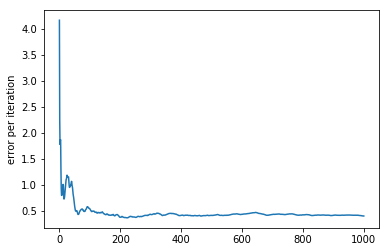

In [11]:
np.random.seed(999)
num_rows = 4
num_cols = 4
num_iterations_generate_x = 10000
num_iterations_generate_x_given_y = 1000

# generate a random picture - first draw x than draw y
x_grid = gibbs_generate_x(num_rows, num_cols, num_iterations_generate_x)
y_grid = generate_y(num_rows, num_cols, x_grid)

# now given y and the true label of each pixel x check the true probability vs the one generated by gibbs
correct_vs_gibbs(x_grid, y_grid, num_rows, num_cols, num_iterations_generate_x_given_y)